# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=1,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-29-38/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4598 | MulticlassF1Score=0.1602
Batch-30 : CrossEntropyLoss=2.5070 | MulticlassF1Score=0.2081
Batch-45 : CrossEntropyLoss=2.4490 | MulticlassF1Score=0.2362
Batch-60 : CrossEntropyLoss=2.4617 | MulticlassF1Score=0.2745
Batch-75 : CrossEntropyLoss=2.4143 | MulticlassF1Score=0.2993
Batch-90 : CrossEntropyLoss=2.4015 | MulticlassF1Score=0.3226
Batch-105: CrossEntropyLoss=2.4039 | MulticlassF1Score=0.3485
Batch-120: CrossEntropyLoss=2.4060 | MulticlassF1Score=0.3702
Batch-135: CrossEntropyLoss=2.3702 | MulticlassF1Score=0.3913
Batch-150: CrossEntropyLoss=2.3627 | MulticlassF1Score=0.4117
Batch-165: CrossEntropyLoss=2.3817 | MulticlassF1Score=0.4297
Batch-180: CrossEntropyLoss=2.3616 | MulticlassF1Score=0.4457
Batch-195: CrossEntropyLoss=2.3486 | MulticlassF1Score=0.4632
Batch-210: CrossEntropyLoss=2.3434 | MulticlassF1Score=0.4783
Batch-225: CrossEntropyLoss=2.3350 | MulticlassF1Score=0.4912
Batch-226: CrossEntropyLoss=2.3719 | MulticlassF1Score=0.4916

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3479 | MulticlassF1Score=0.6649
Batch-30 : CrossEntropyLoss=2.3423 | MulticlassF1Score=0.6677
Batch-45 : CrossEntropyLoss=2.3504 | MulticlassF1Score=0.6750
Batch-60 : CrossEntropyLoss=2.3502 | MulticlassF1Score=0.6751
Batch-63 : CrossEntropyLoss=2.3419 | MulticlassF1Score=0.6753

Training   : Mean CrossEntropyLoss = 2.4159 | Mean MulticlassF1Score = 0.3442
Validation : Mean CrossEntropyLoss = 2.3491 | Mean MulticlassF1Score = 0.6697

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3503 | MulticlassF1Score=0.6738
Batch-30 : CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6817
Batch-45 : CrossEntropyLoss=2.3548 | MulticlassF1Score=0.6828
Batch-60 : CrossEntropyLoss=2.3369 | MulticlassF1Score=0.6839
Batch-75 : CrossEntropyLoss=2.3398 | MulticlassF1Score=0.6822
Batch-90 : CrossEntropyLoss=2.3361 | MulticlassF1Score=0.6816
Batch-105: CrossEntropyLoss=2.3456 | MulticlassF1Score=0.6809
Batch-120: CrossEntropyLoss=2.3582 | MulticlassF1Score=0.6856
Batch-135: CrossEntropyLoss=2.3255 | MulticlassF1Score=0.6921
Batch-150: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.6996
Batch-165: CrossEntropyLoss=2.3209 | MulticlassF1Score=0.7056
Batch-180: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.7114
Batch-195: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7173
Batch-210: CrossEntropyLoss=2.3232 | MulticlassF1Score=0.7224
Batch-225: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7274
Batch-226: CrossEntropyLoss=2.3215 | MulticlassF1Score=0.7275

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7903
Batch-30 : CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7885
Batch-45 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7884
Batch-60 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7891
Batch-63 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3331 | Mean MulticlassF1Score = 0.6935
Validation : Mean CrossEntropyLoss = 2.3137 | Mean MulticlassF1Score = 0.7880

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7889
Batch-30 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7952
Batch-45 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7939
Batch-60 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.7947
Batch-75 : CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7937
Batch-90 : CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7932
Batch-105: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7934
Batch-120: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7935
Batch-135: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7933
Batch-150: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7939
Batch-165: CrossEntropyLoss=2.3064 | MulticlassF1Score=0.7942
Batch-180: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7942
Batch-195: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.7942
Batch-210: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7946
Batch-225: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7952
Batch-226: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.7953

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3187 | MulticlassF1Score=0.8087
Batch-30 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8073
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8057
Batch-60 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8043
Batch-63 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.8042

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3116 | Mean MulticlassF1Score = 0.7939
Validation : Mean CrossEntropyLoss = 2.3095 | Mean MulticlassF1Score = 0.8073

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8074
Batch-30 : CrossEntropyLoss=2.3151 | MulticlassF1Score=0.8079
Batch-45 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8103
Batch-60 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8114
Batch-75 : CrossEntropyLoss=2.3127 | MulticlassF1Score=0.8107
Batch-90 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8112
Batch-105: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8107
Batch-120: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8114
Batch-135: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8109
Batch-150: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8104
Batch-165: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8099
Batch-180: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8094
Batch-195: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8093
Batch-210: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8091
Batch-225: CrossEntropyLoss=2.3219 | MulticlassF1Score=0.8090
Batch-226: CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8090

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8085
Batch-30 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8080
Batch-45 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.8081
Batch-60 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8078
Batch-63 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.8068

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3070 | Mean MulticlassF1Score = 0.8104
Validation : Mean CrossEntropyLoss = 2.3077 | Mean MulticlassF1Score = 0.8081

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8089
Batch-30 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8097
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8102
Batch-60 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8109
Batch-75 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8105
Batch-90 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8110
Batch-105: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8127
Batch-120: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8140
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8147
Batch-150: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8152
Batch-165: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8156
Batch-180: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8157
Batch-195: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8160
Batch-210: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8163
Batch-225: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8169
Batch-226: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8170

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8162
Batch-30 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8193
Batch-45 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8178
Batch-60 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8163
Batch-63 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8158

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3044 | Mean MulticlassF1Score = 0.8132
Validation : Mean CrossEntropyLoss = 2.3049 | Mean MulticlassF1Score = 0.8178

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8166
Batch-30 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8185
Batch-45 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8169
Batch-60 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8166
Batch-75 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8194
Batch-90 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8220
Batch-105: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8243
Batch-120: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8264
Batch-135: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8292
Batch-150: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8308
Batch-165: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8318
Batch-180: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8325
Batch-195: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8330
Batch-210: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8336
Batch-225: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8345
Batch-226: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8345

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8374
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8374
Batch-45 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8368
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8369
Batch-63 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8370

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8251
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8368

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8416
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8421
Batch-45 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8422
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8419
Batch-75 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8402
Batch-90 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8407
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8405
Batch-120: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8412
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8413
Batch-150: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8420
Batch-165: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8432
Batch-180: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8451
Batch-195: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8456
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8466
Batch-225: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8470
Batch-226: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8502
Batch-30 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8514
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8516
Batch-60 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8527
Batch-63 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8526

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2951 | Mean MulticlassF1Score = 0.8423
Validation : Mean CrossEntropyLoss = 2.2937 | Mean MulticlassF1Score = 0.8514

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8605
Batch-30 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8576
Batch-45 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8590
Batch-60 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8608
Batch-75 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8601
Batch-90 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8610
Batch-105: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8605
Batch-120: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8604
Batch-135: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8597
Batch-150: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8595
Batch-165: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8594
Batch-180: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8596
Batch-195: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8597
Batch-210: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8597
Batch-225: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8598
Batch-226: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8585
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8551
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8548
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8542
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8540

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8596
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8567

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8694
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8662
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8642
Batch-60 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8642
Batch-75 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8626
Batch-90 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8625
Batch-105: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8624
Batch-120: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8621
Batch-135: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8616
Batch-150: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8624
Batch-165: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8624
Batch-180: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8621
Batch-195: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8618
Batch-210: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8617
Batch-225: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8614
Batch-226: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8613

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8560
Batch-30 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8568
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8563
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8552
Batch-63 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8551

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2906 | Mean MulticlassF1Score = 0.8636
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8553

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8633
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8615
Batch-45 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8617
Batch-60 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8622
Batch-75 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8639
Batch-90 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8671
Batch-105: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8693
Batch-120: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8716
Batch-135: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8736
Batch-150: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8752
Batch-165: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8766
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8772
Batch-195: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8783
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8793
Batch-225: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8800
Batch-226: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8800

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8830
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8815
Batch-45 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8831
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8839

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8704
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8824

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8902
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8933
Batch-45 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8935
Batch-75 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8929
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8928
Batch-105: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8927
Batch-120: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8930
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8935
Batch-165: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8939
Batch-180: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8940
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8938
Batch-210: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8938
Batch-225: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8939
Batch-226: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8939

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8876
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8863
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8864

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8931
Validation : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8866

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8995
Batch-60 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8986
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8978
Batch-90 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8981
Batch-105: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8977
Batch-120: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8974
Batch-135: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8975
Batch-150: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8973
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8976
Batch-180: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8975
Batch-195: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8972
Batch-210: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8971
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8969
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8969

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8859
Batch-30 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8888
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8886
Batch-63 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8881

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2797 | Mean MulticlassF1Score = 0.8976
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8889

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9020
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8996
Batch-60 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8995
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9003
Batch-90 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9009
Batch-105: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9006
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9001
Batch-135: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8996
Batch-150: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8989
Batch-165: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8991
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8991
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8994
Batch-225: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8990
Batch-226: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8990

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8873
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8868
Batch-60 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8882
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8884

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.9002
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8895

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8999
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8990
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8999
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9008
Batch-75 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9005
Batch-90 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9000
Batch-105: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8997
Batch-120: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8999
Batch-135: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8998
Batch-150: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9004
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9008
Batch-180: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.9010
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9008
Batch-210: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9008
Batch-225: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9004
Batch-226: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9004

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8905
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8898
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8893
Batch-63 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8894

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.9003
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8897

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.9029
Batch-30 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9049
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9041
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9051
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9039
Batch-90 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9031
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9030
Batch-135: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.9029
Batch-150: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.9025
Batch-165: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9026
Batch-180: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9021
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9016
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9017
Batch-225: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9018
Batch-226: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9018

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8856
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8865
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8885
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8890

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9032
Validation : Mean CrossEntropyLoss = 2.2821 | Mean MulticlassF1Score = 0.8866

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9040
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9017
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9002
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9012
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9017
Batch-90 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9019
Batch-105: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9026
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9022
Batch-135: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9022
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9023
Batch-165: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9025
Batch-180: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9023
Batch-195: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9023
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9025
Batch-225: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9024
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9024

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8910
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8898
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8888

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9022
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8908

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9020
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9014
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9021
Batch-75 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9023
Batch-90 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9023
Batch-105: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9022
Batch-120: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9017
Batch-135: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9024
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9022
Batch-180: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9021
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9023
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9026
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9032
Batch-226: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9032

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8899
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8904
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8887
Batch-63 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8891

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9027
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8908

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9036
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9036
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9039
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9039
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9044
Batch-105: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9038
Batch-120: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9033
Batch-135: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9035
Batch-150: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9036
Batch-165: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9038
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9044
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9042
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9040
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9040

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8923
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8910
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8902
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8898
Batch-63 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8893

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9041
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8902

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9057
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9047
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9050
Batch-75 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9049
Batch-90 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.9041
Batch-105: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9044
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9041
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9049
Batch-150: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9044
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9047
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9048
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9043
Batch-225: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9046
Batch-226: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9046

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8890
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.8896
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8903

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2770 | Mean MulticlassF1Score = 0.9044
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8888

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9001
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9027
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9062
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9118
Batch-75 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9156
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9183
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9202
Batch-120: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9211
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9226
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9238
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9257
Batch-195: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9263
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9271
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9276
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9276

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9206
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9216
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9176
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9199

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9376
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9374
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9370
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9370
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9365
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9364
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9367
Batch-165: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9366
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9366
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9365
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9365
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9218

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9223

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9340
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9344
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9360
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9368
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9369
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9375
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9379
Batch-180: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9378
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9365
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9253

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9388
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9388
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9394
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9392
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9392

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9393
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9221

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9417
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9412
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9407
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9403
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9402
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9400
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9400
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9400

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9244

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9401
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9403
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9401
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9404
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9403
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9406
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9406

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9220

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9402
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9405
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9224

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9410
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9417
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9419
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9421
Batch-210: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9420

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9232
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9232

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9417
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9235

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9431
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9423
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9255

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9401
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9412
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9411
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9418
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9418
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9420
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9420
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9423
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9414
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9237

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9217
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9228
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9232

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9234

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9247
Patience = 1/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9447
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9447
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9438
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9244

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9446
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9226

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9446
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9245
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9247

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9238

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9244
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9456
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9252

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9480
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9492
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9508
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9517
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9524
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9534
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9541
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9540

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9438

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2617 | Mean MulticlassF1Score = 0.9485
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9459

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9654
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9651
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9646
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9647
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9646
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9437

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9657
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9443

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9650
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9647
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9651
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9652
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9647
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9650
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9651
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9447

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9601
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9622
Batch-45 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9630
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9628
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9635
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9637
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9638
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9642
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9644
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9644
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9446

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9632
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9449
Patience = 2/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9665
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9649
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9651
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9650
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9653
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9657

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9452

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9654
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9461

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9655
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9650
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9653
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9657
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9661
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9663

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9456
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9458

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9475

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9682
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9667
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9665
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9448

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9444

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9662
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9665
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9496
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9728
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9472

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9490

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9723
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9714
Batch-75 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9701
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9464

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9483

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9480
Patience = 3/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9480

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9727
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2568
Best CrossEntropyLoss training    : 2.2636
Best MulticlassF1Score validation : 0.9699
Best MulticlassF1Score validation : 0.9478
Training duration                 : 2.2195 minutes.
Training date                     : 2022-10-19 13:31:52.122781+08:00


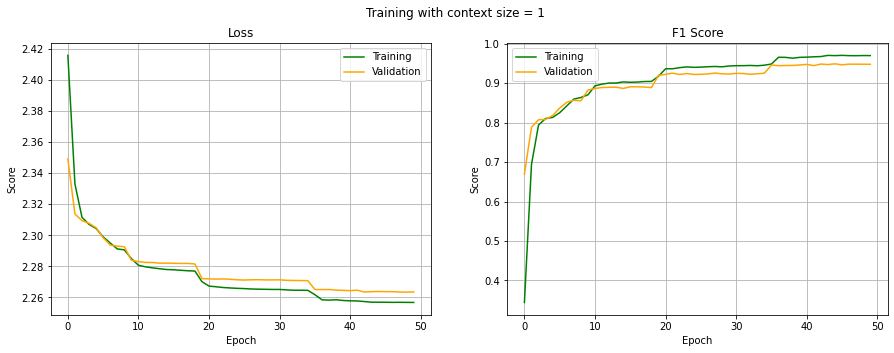

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9703, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9495, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9703, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9495, device='cuda:0'))

## Heatmap

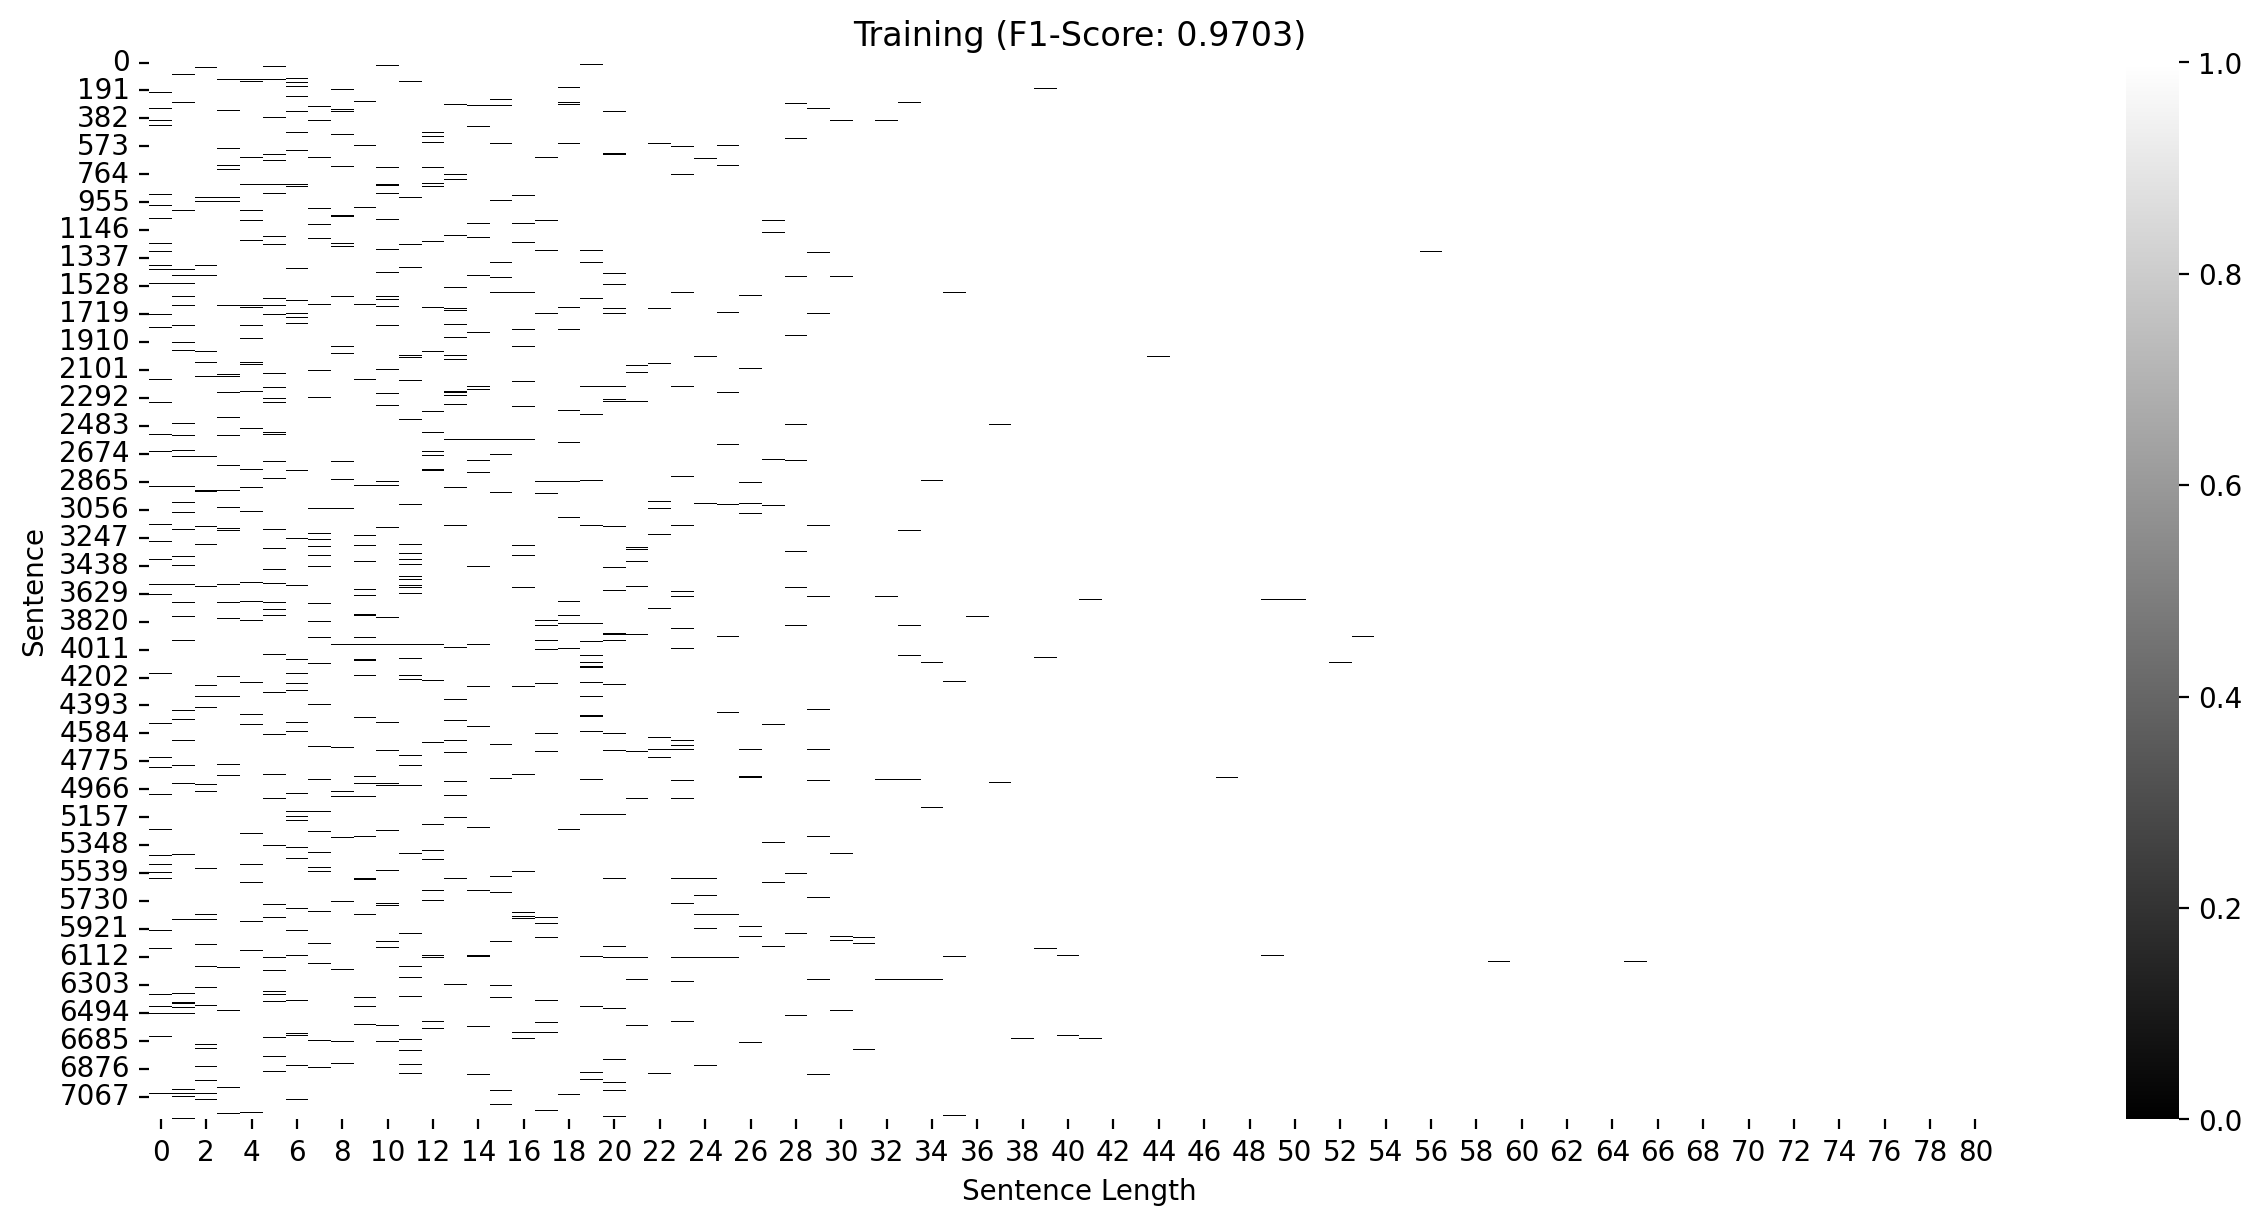

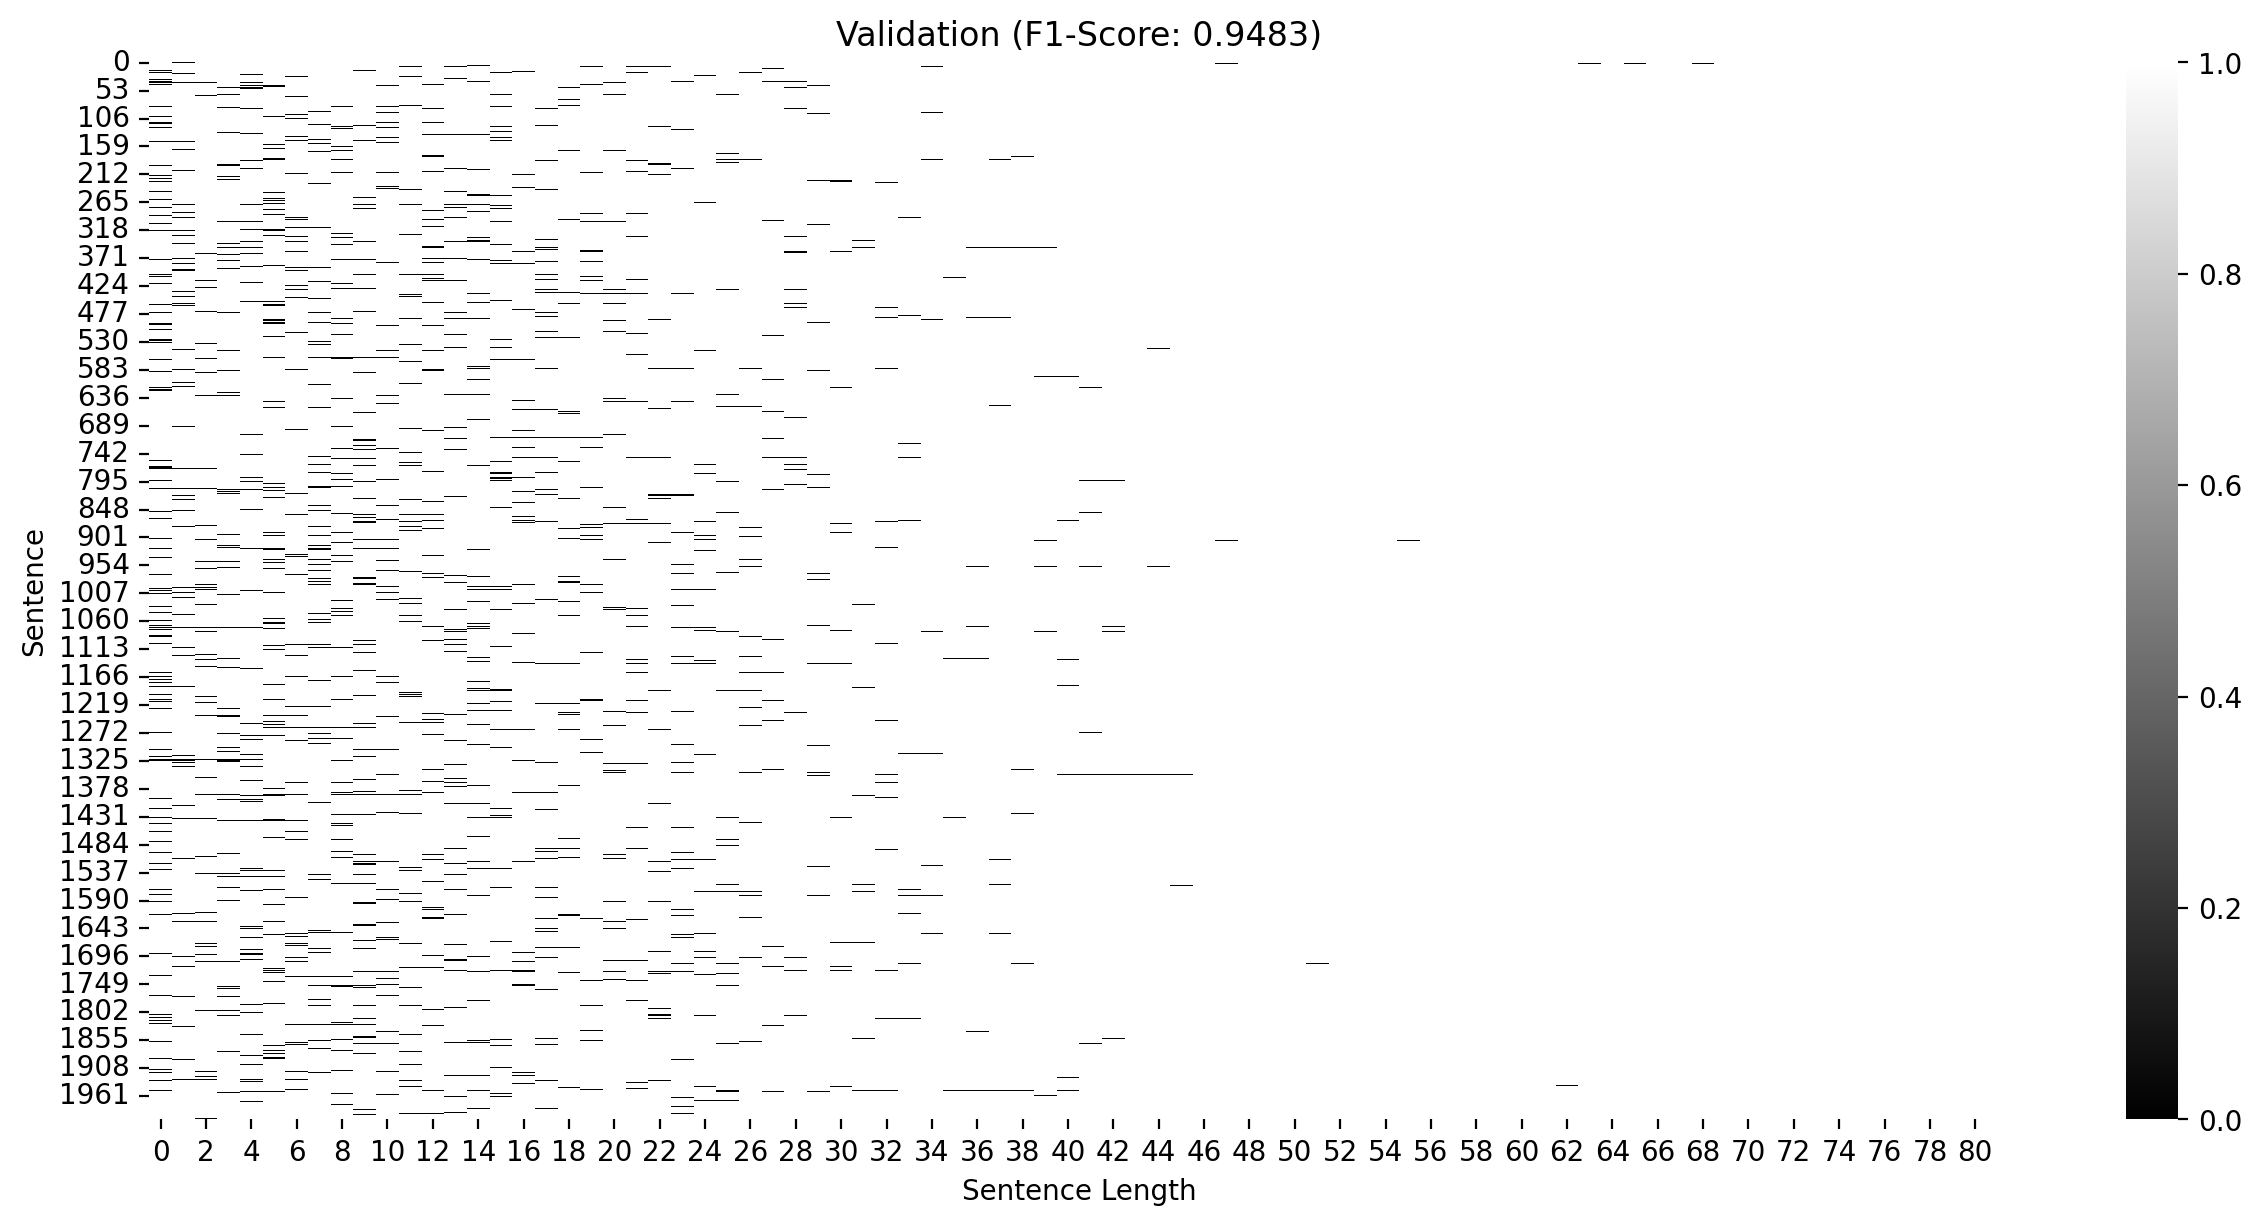

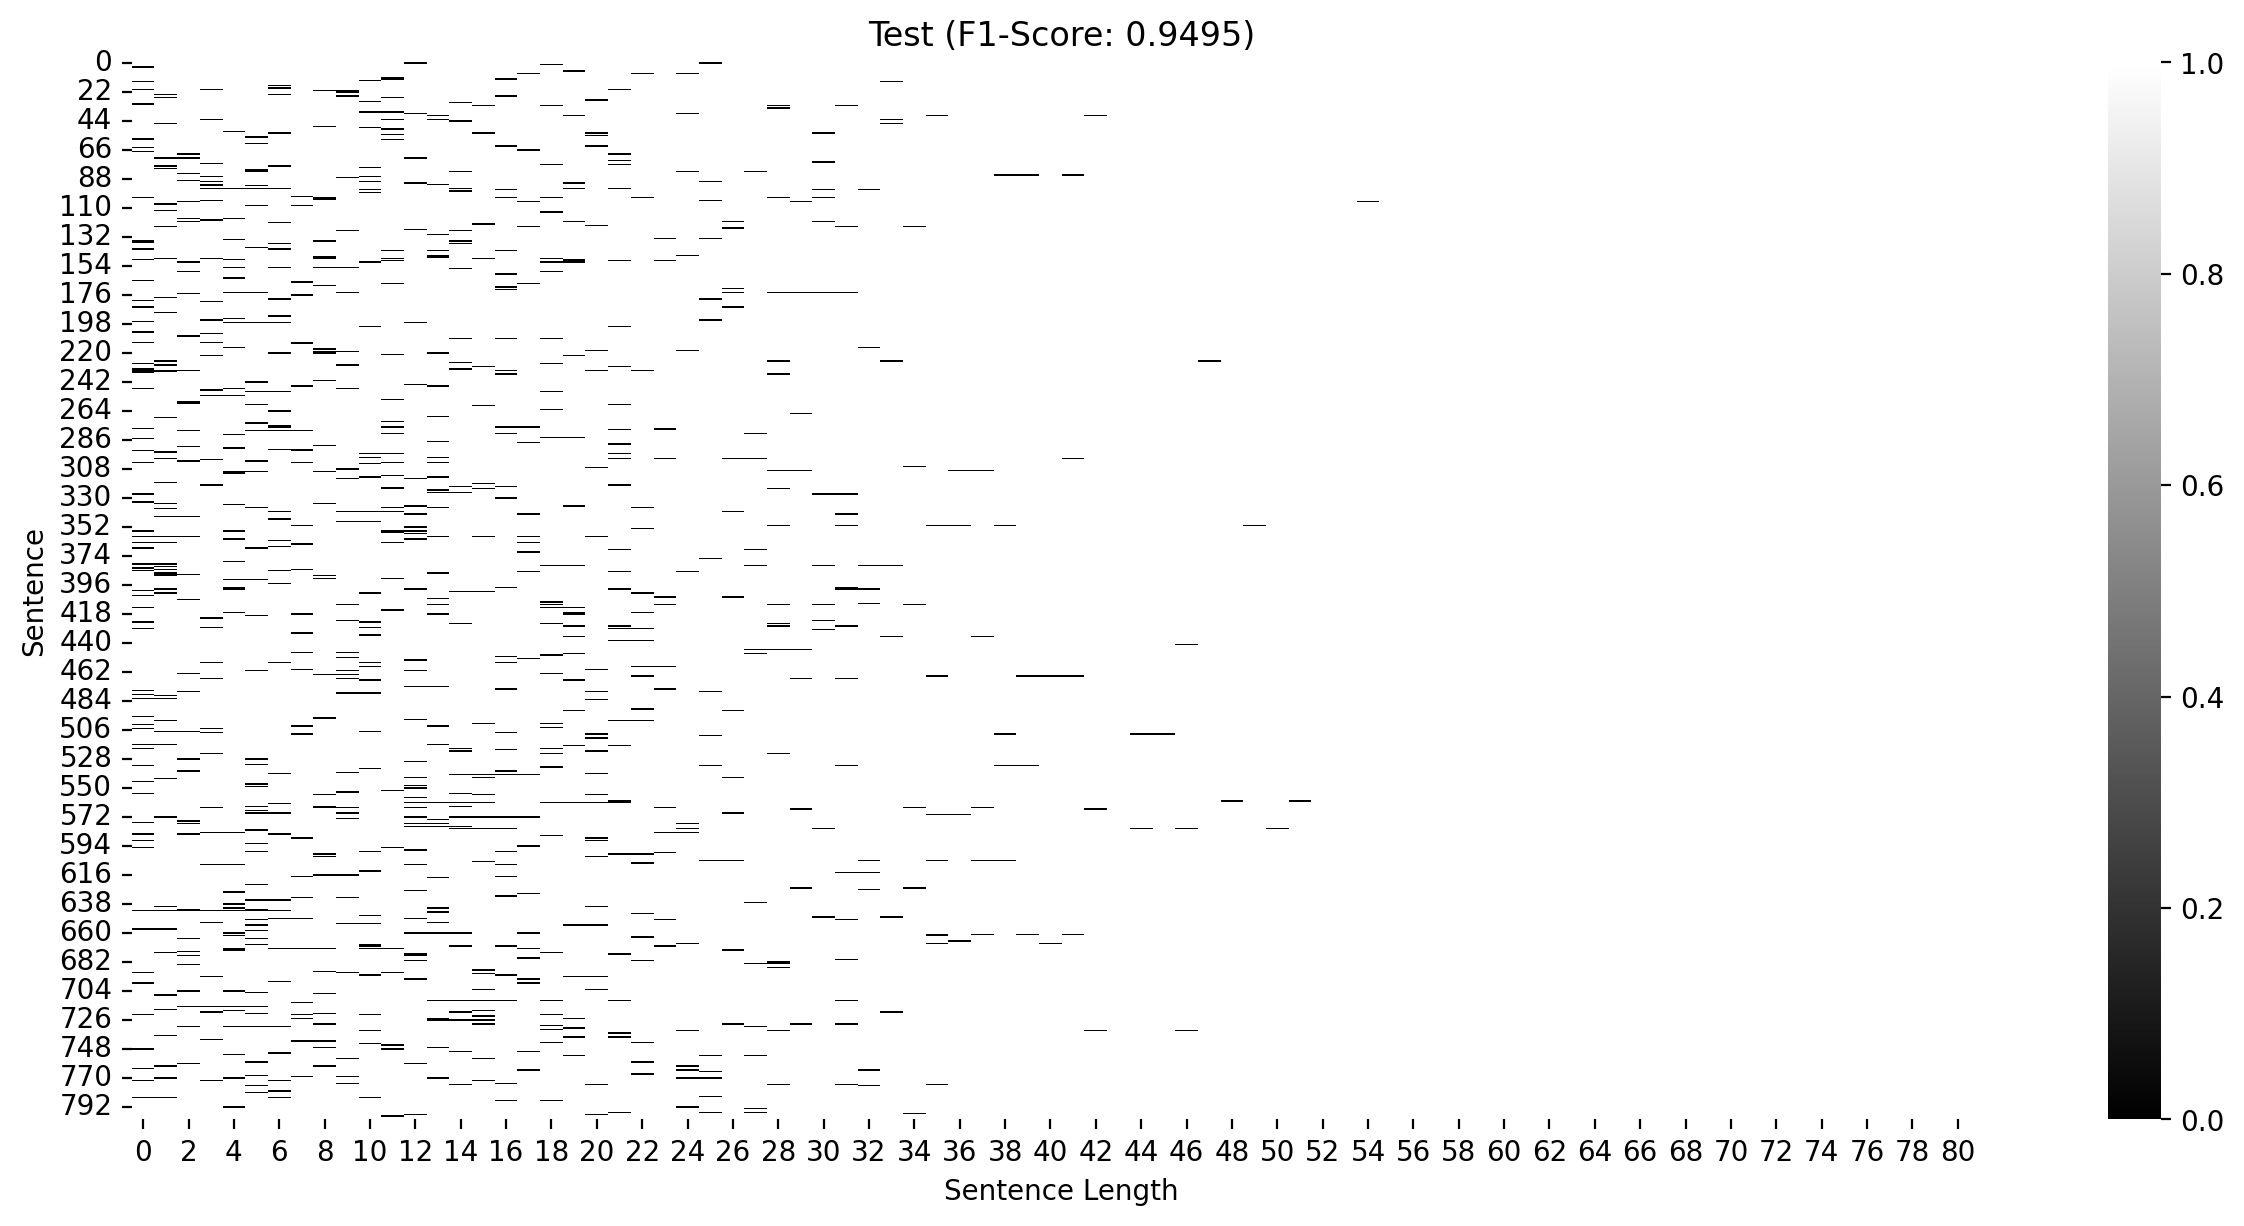

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


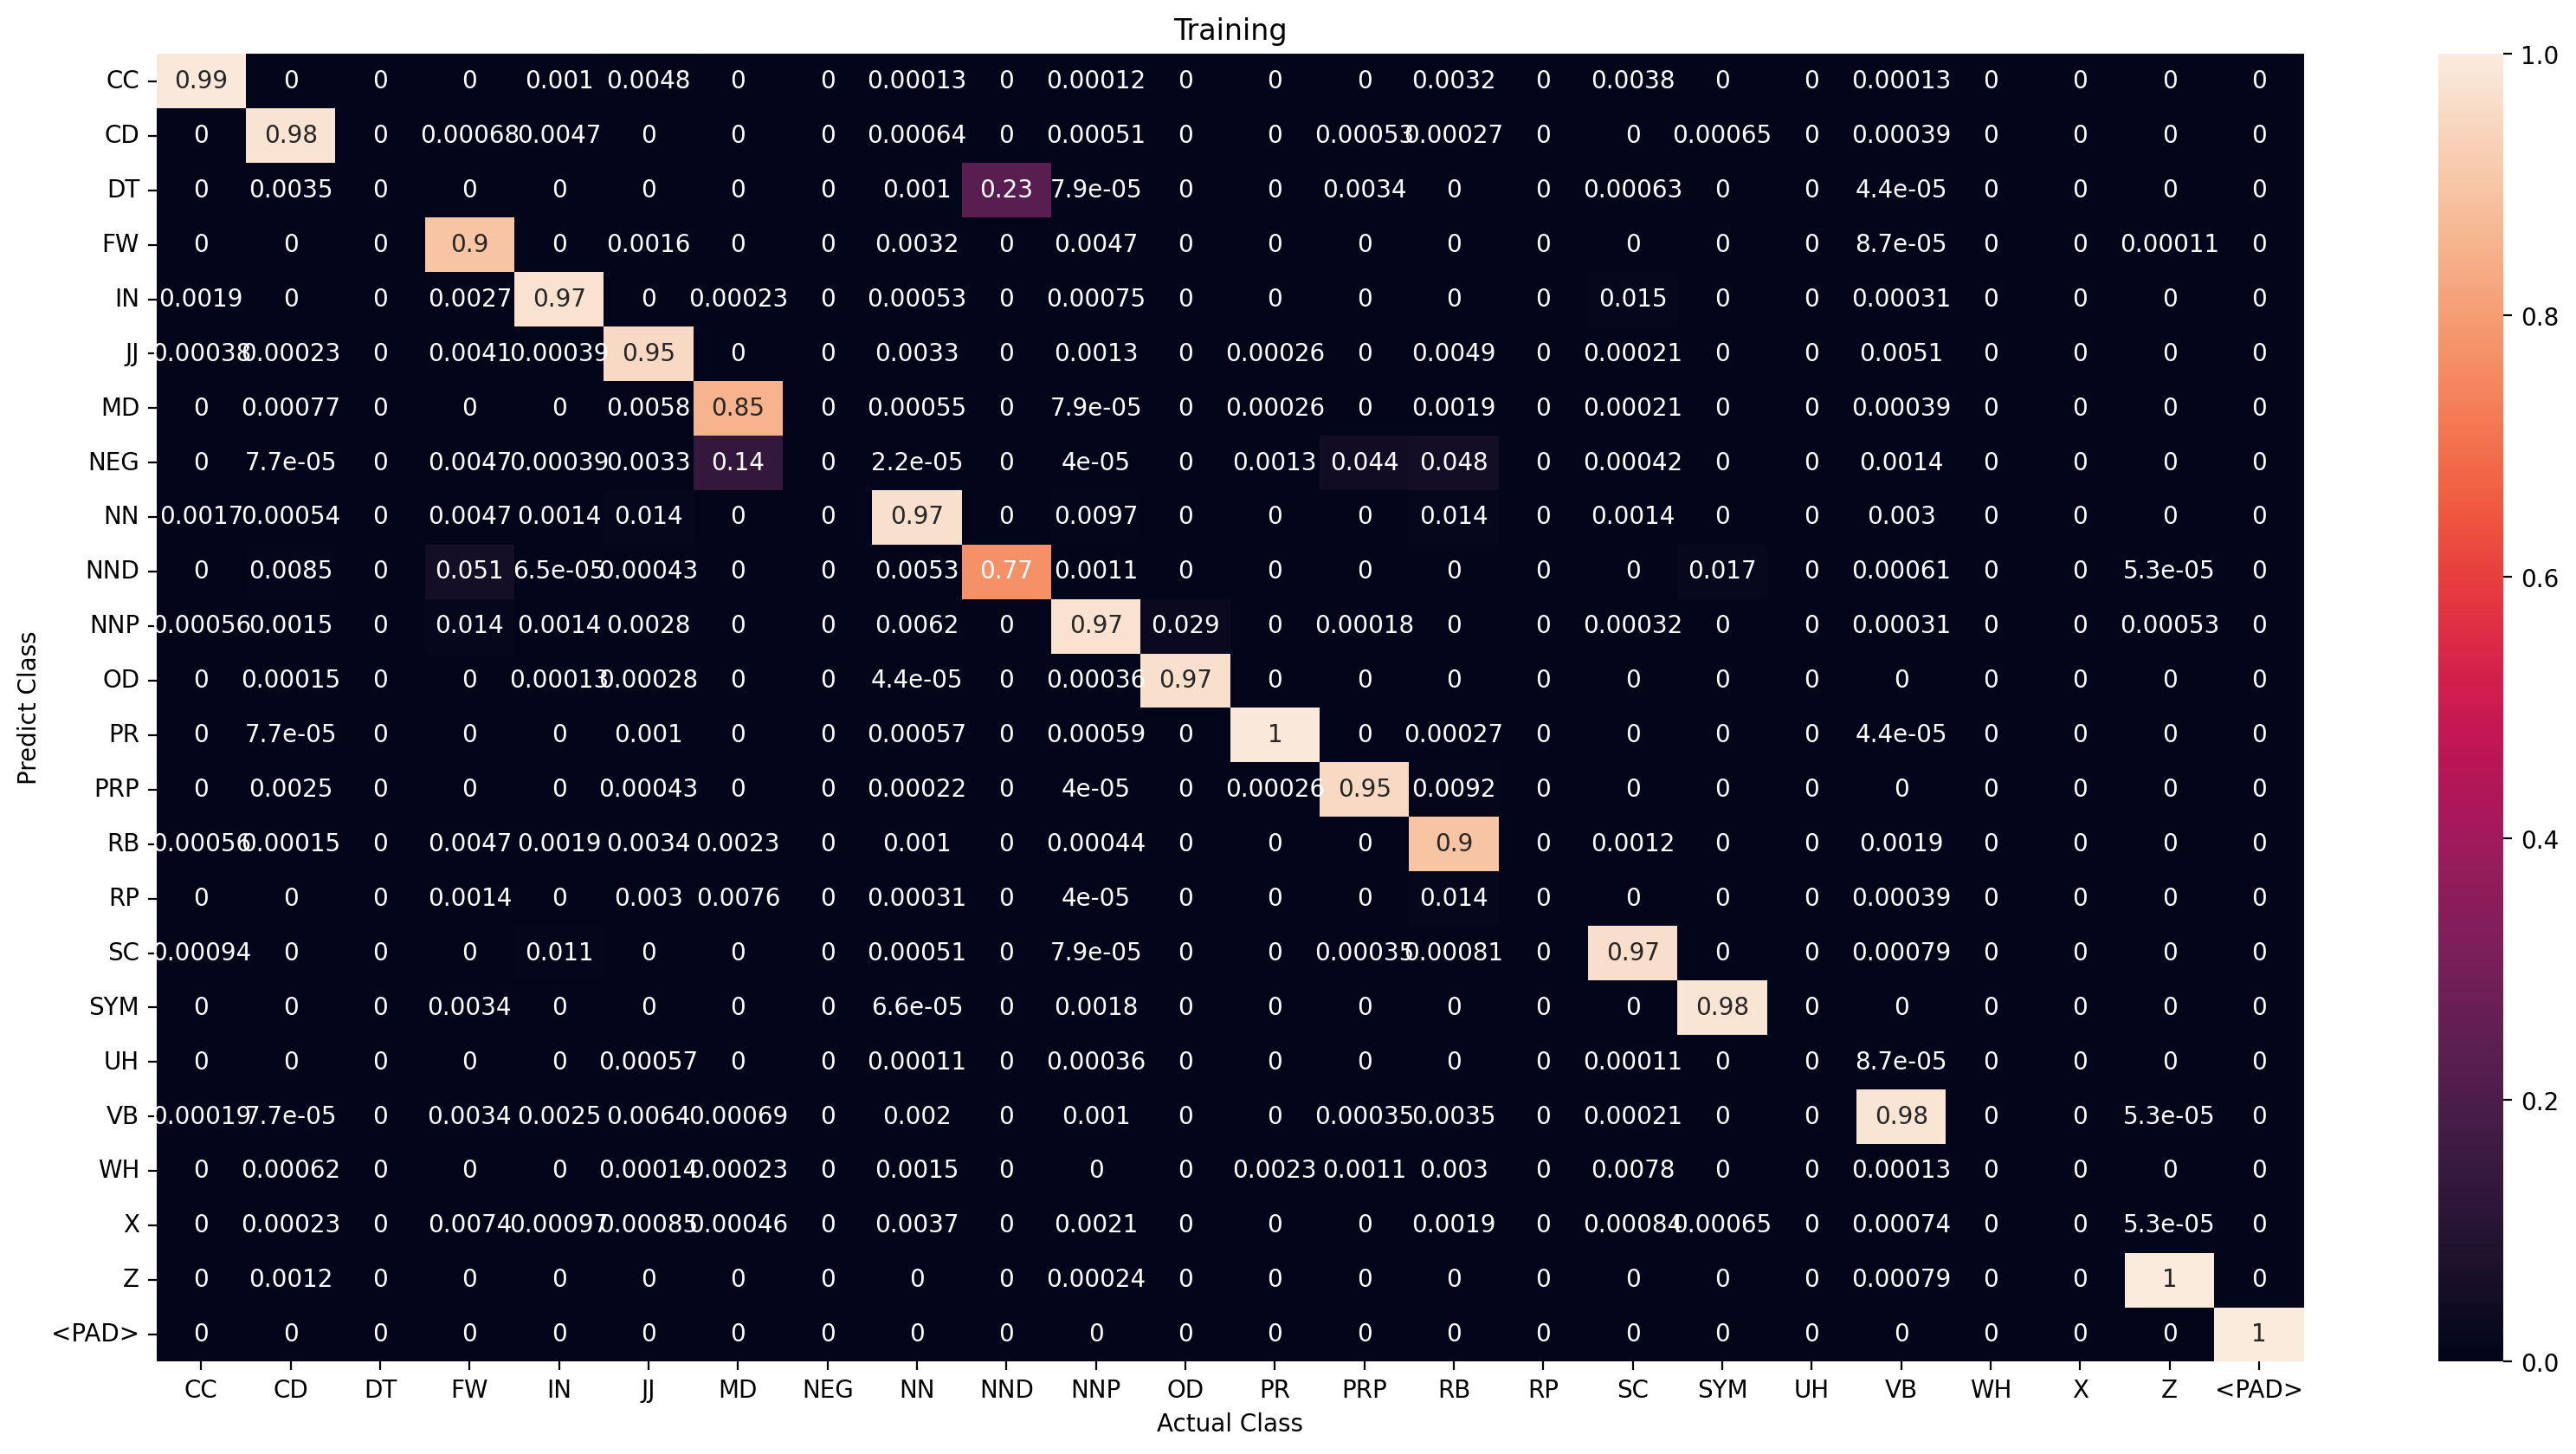

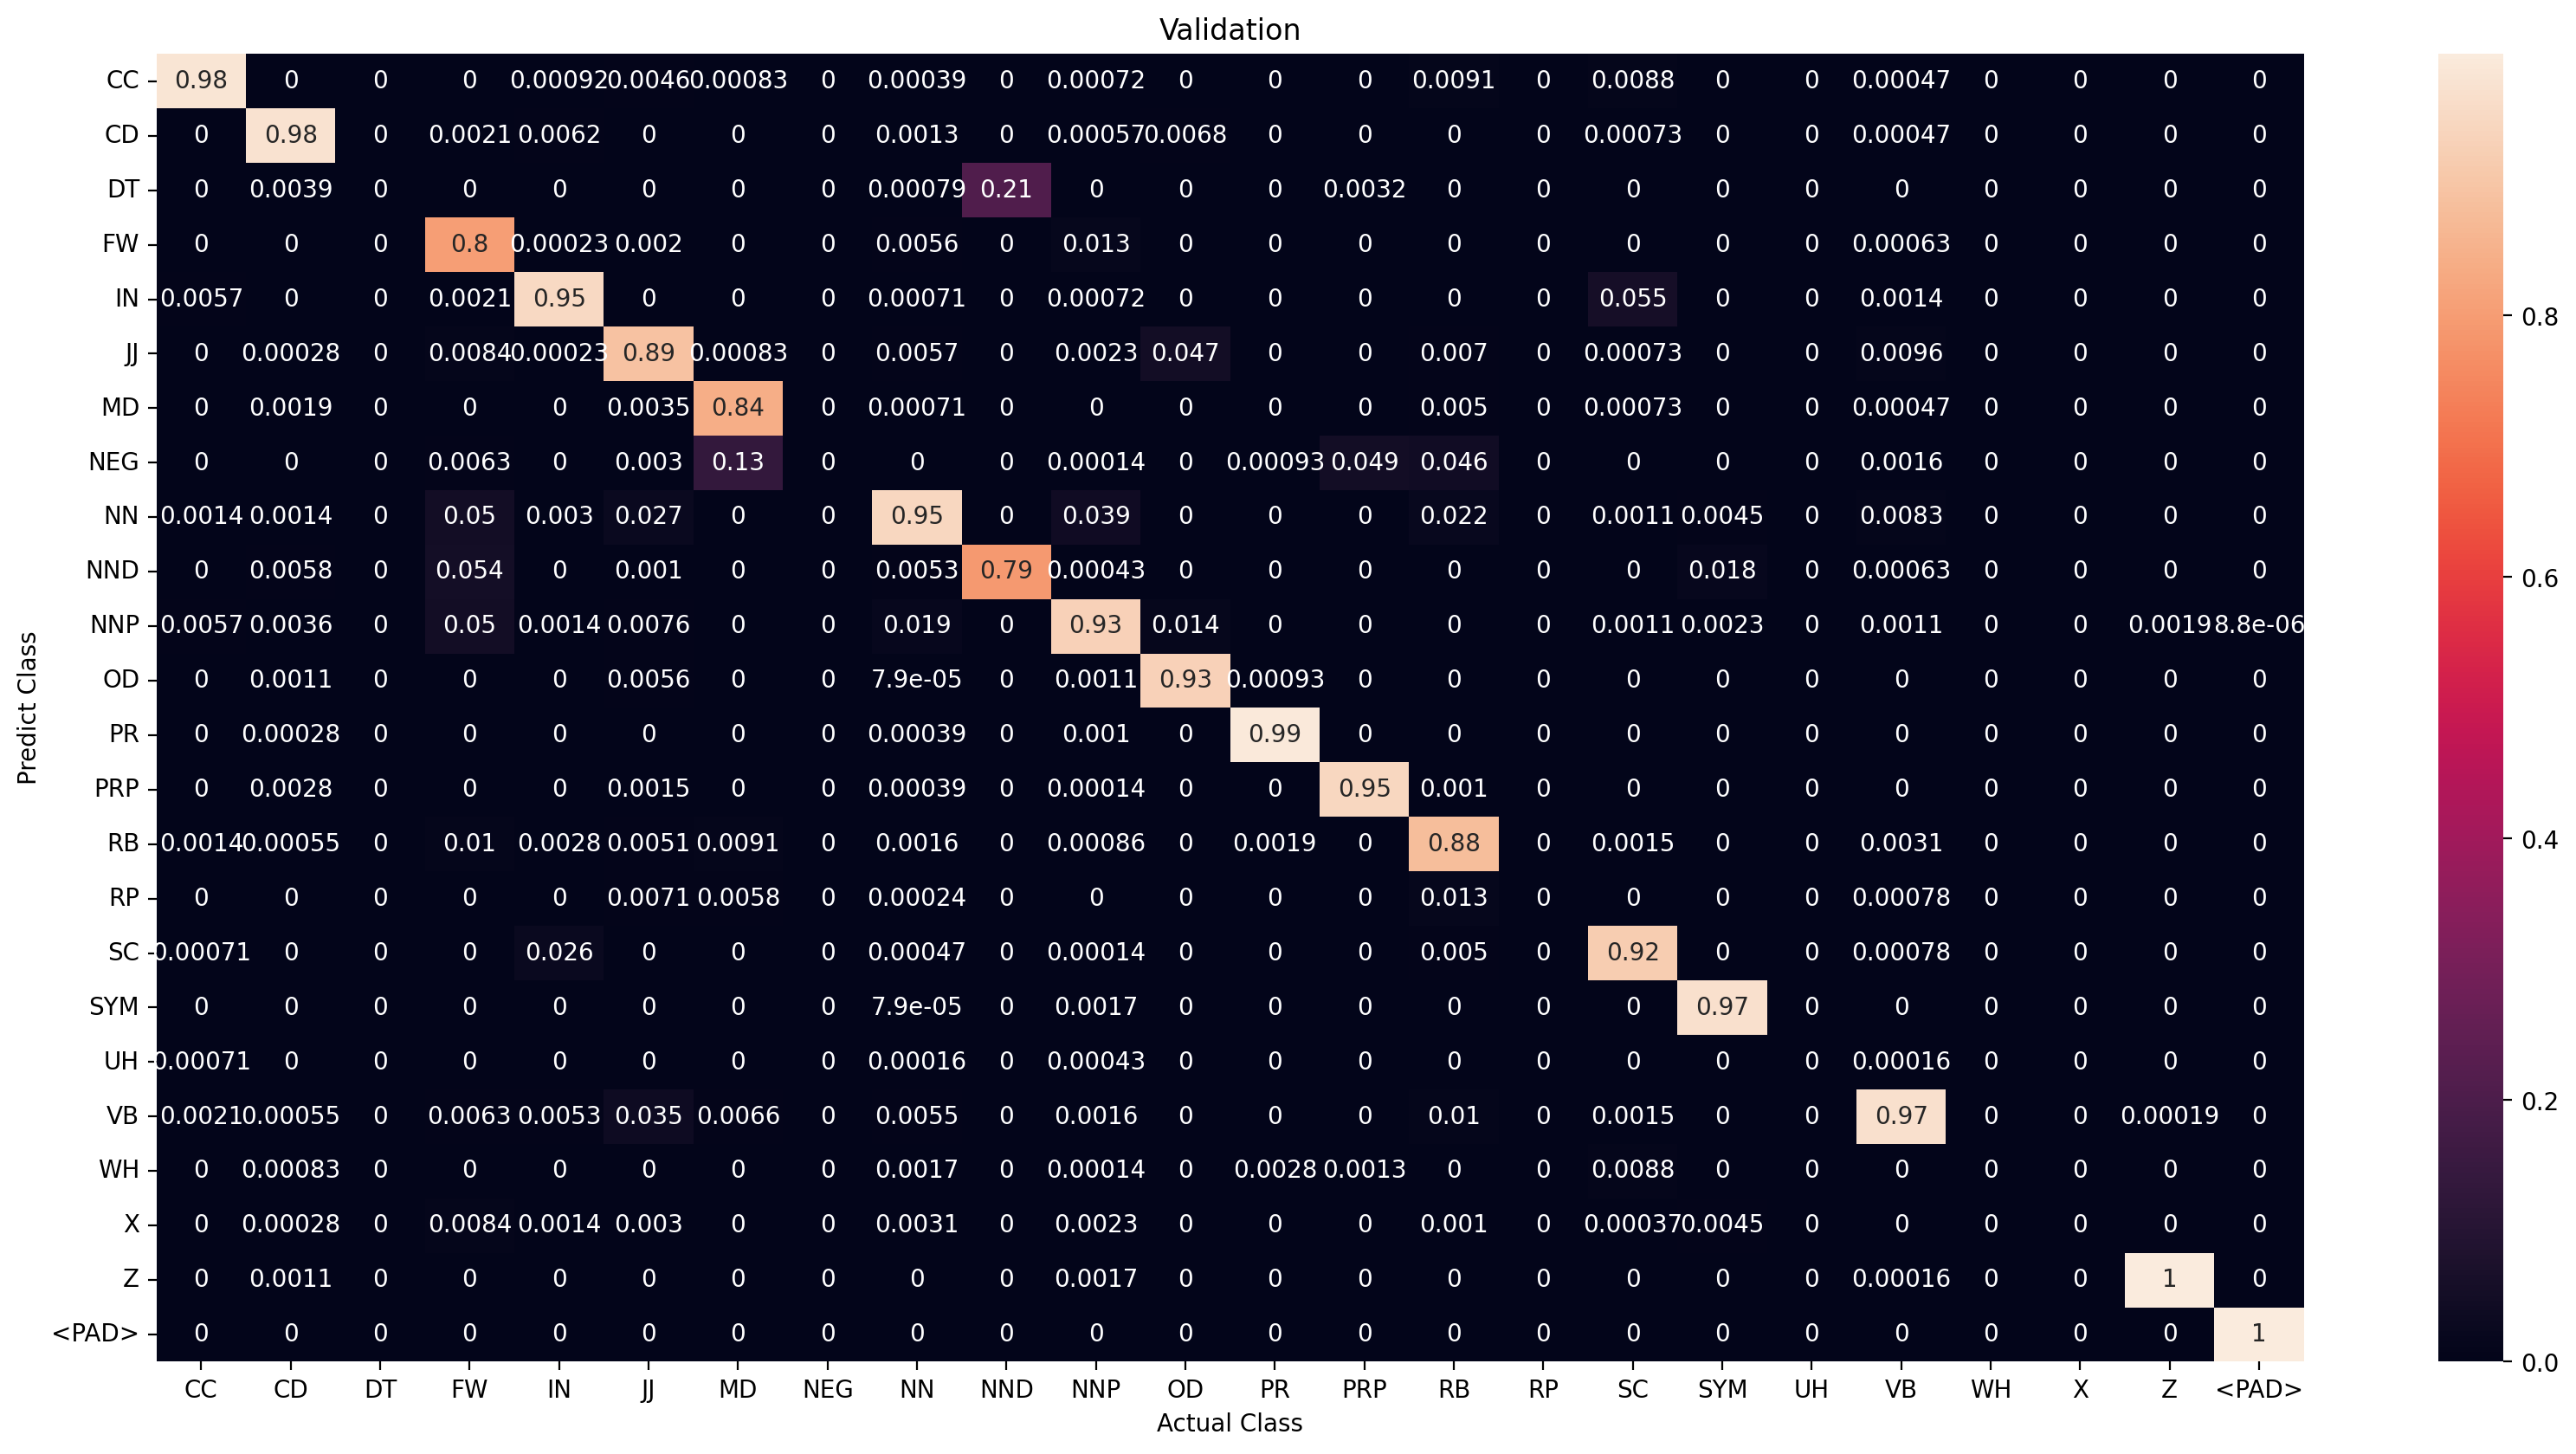

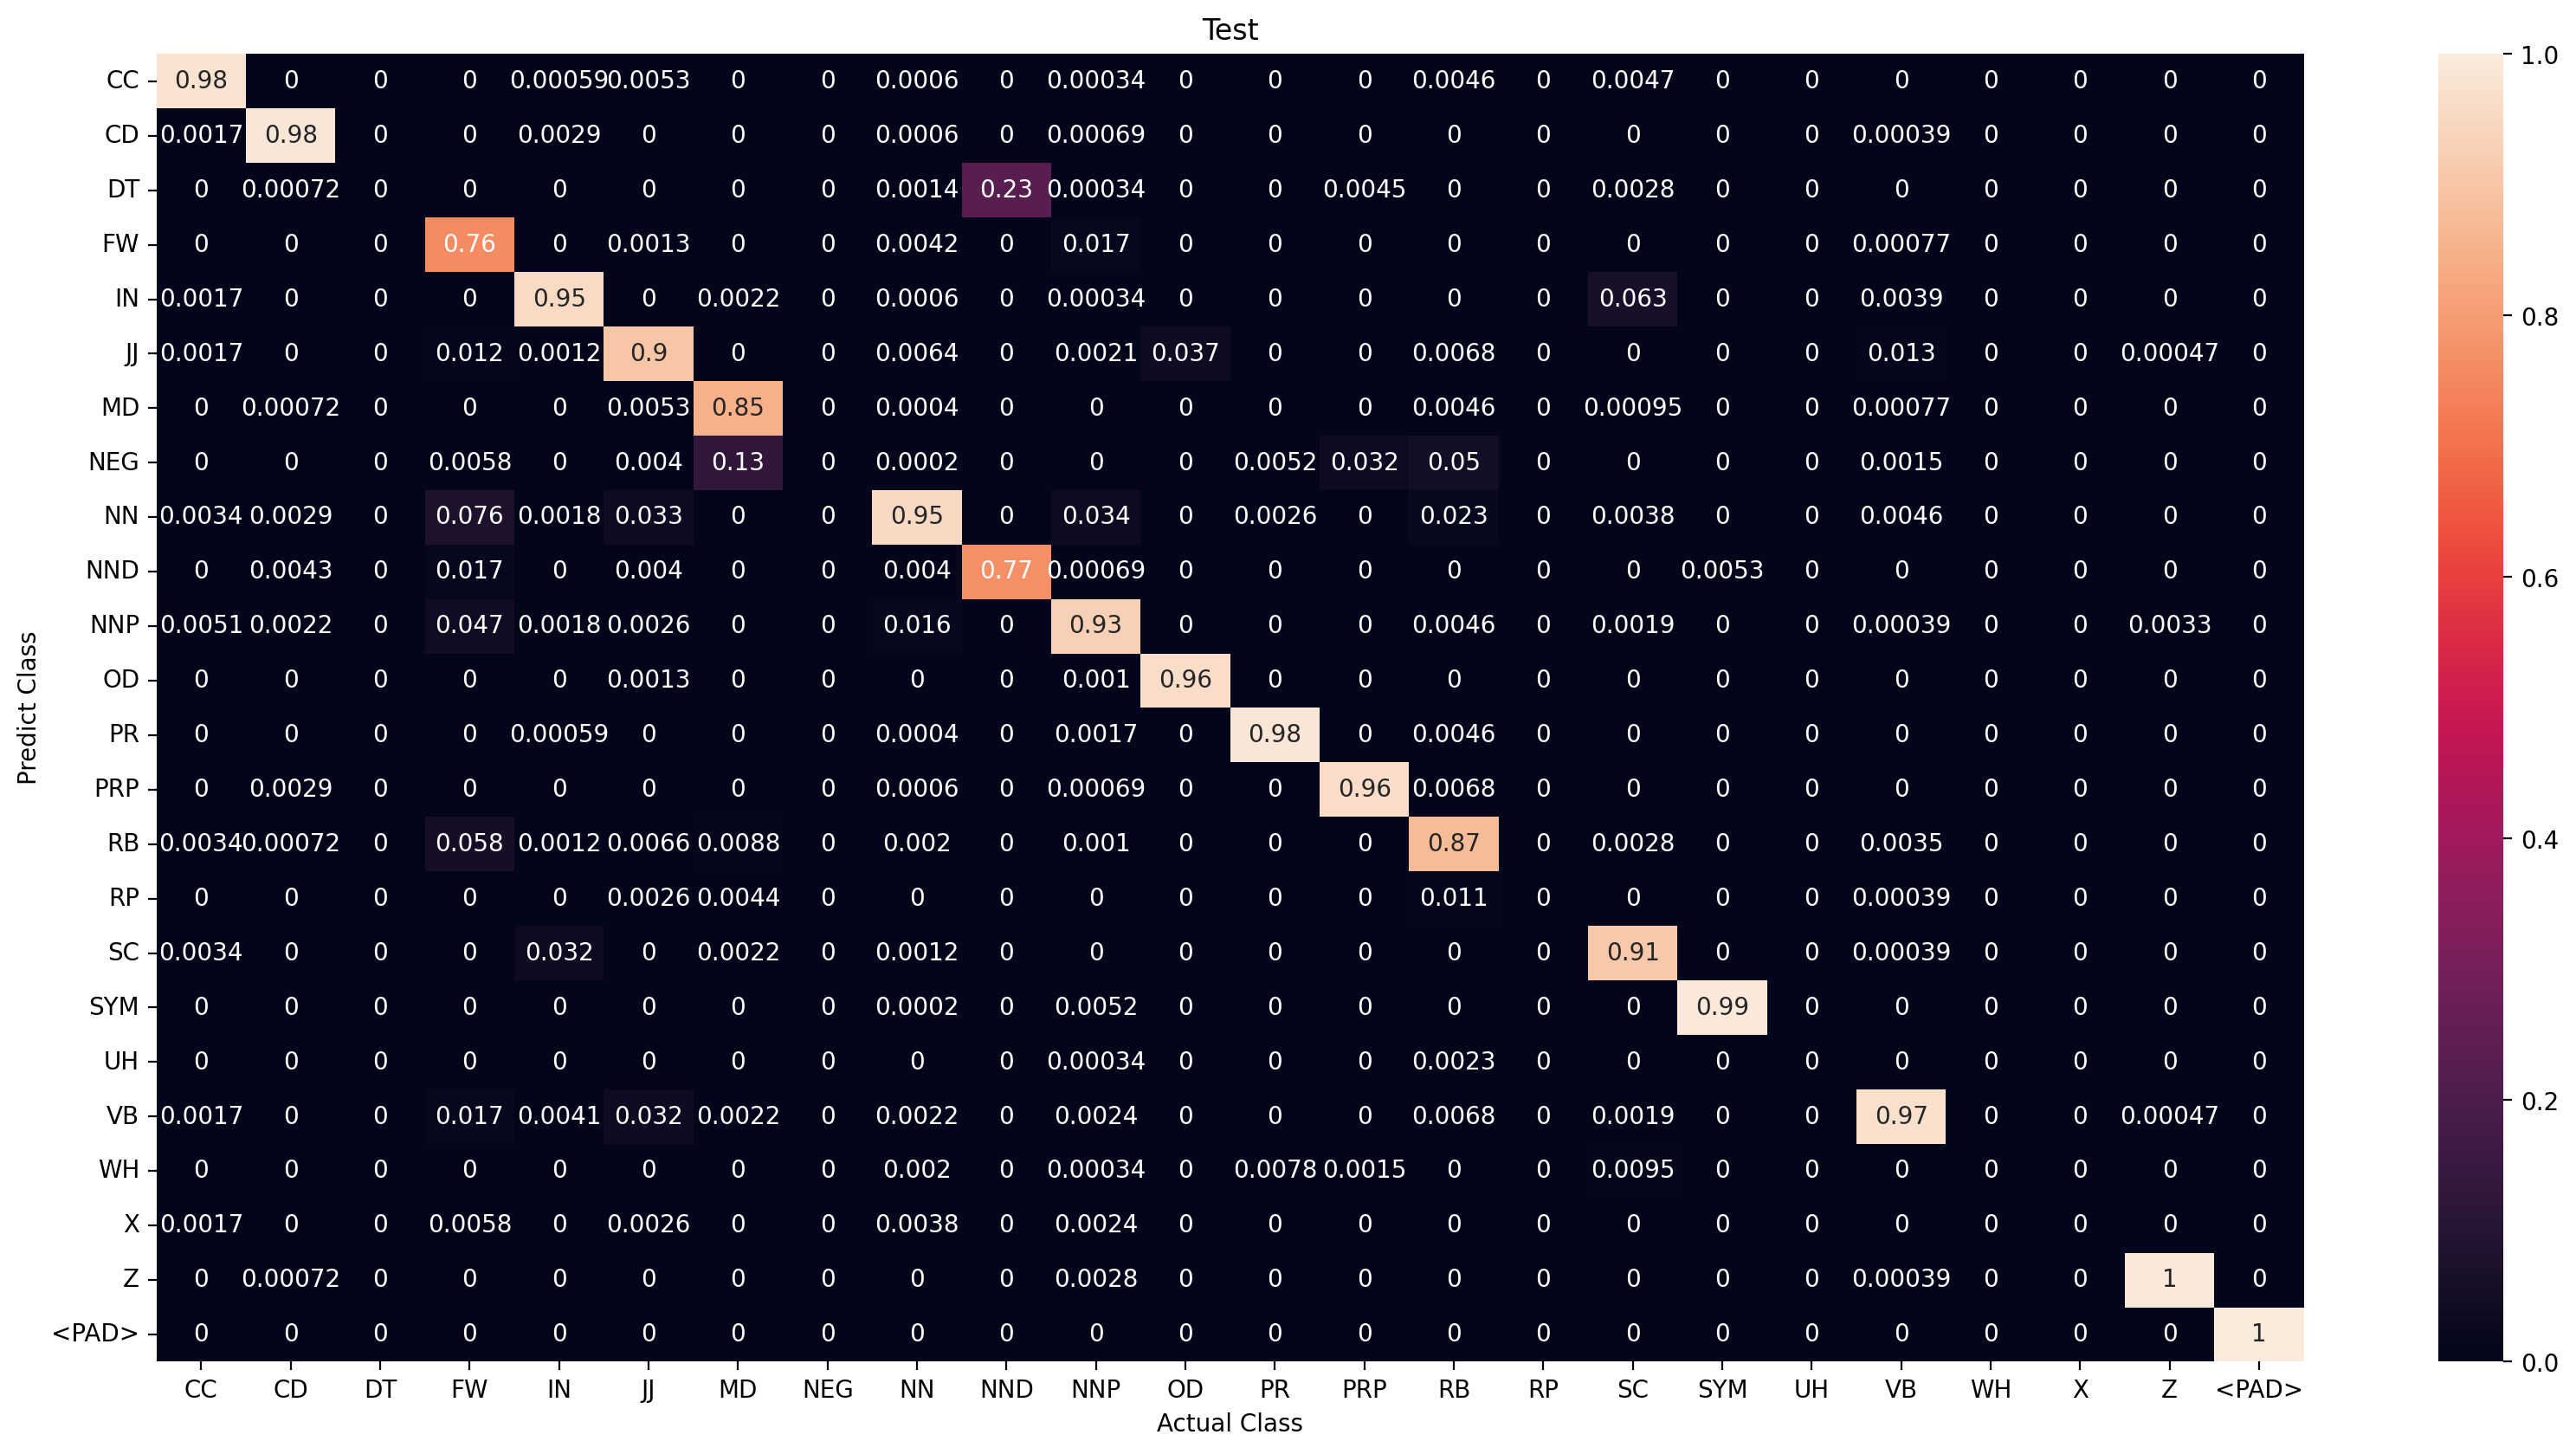

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5287       | CC    : 110      |
| CD    : 12862  | CD    : 12732      | CD    : 130      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1326       | FW    : 279      |
| IN    : 15290  | IN    : 15079      | IN    : 211      |
| JJ    : 7025   | JJ    : 6687       | JJ    : 338      |
| MD    : 3798   | MD    : 3701       | MD    : 97       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43952      | NN    : 520      |
| NND   : 1033   | NND   : 533        | NND   : 500      |
| NNP   : 25007  | NNP   : 24608      | NNP   : 399      |
| OD    : 519    | OD    : 502        | OD    : 17       |
| PR    : 3880   | PR    : 3829       | PR    : 51       |
| PRP   : 5449   | PRP   : 5368       | PRP   : 81       |
| RB    : 3502   | RB    : 3314       | RB    : 188      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11323
Wrong prediction            : 648
Percentage correct oov pred : 94.58691838609974

Validation
Number OOV token            : 3190
Correct prediction          : 2862
Wrong prediction            : 328
Percentage correct oov pred : 89.71786833855799

Test
Number OOV token            : 1401
Correct prediction          : 1274
Wrong prediction            : 127
Percentage correct oov pred : 90.93504639543183



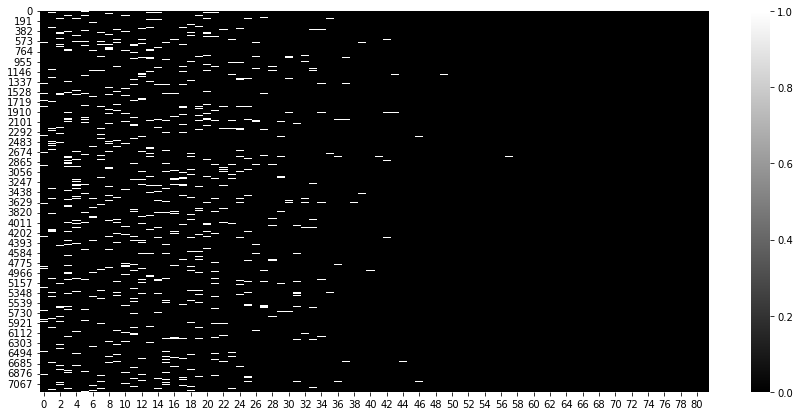

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

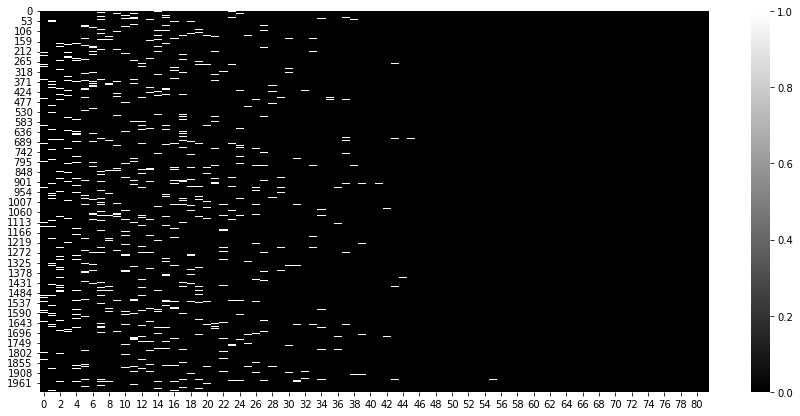

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

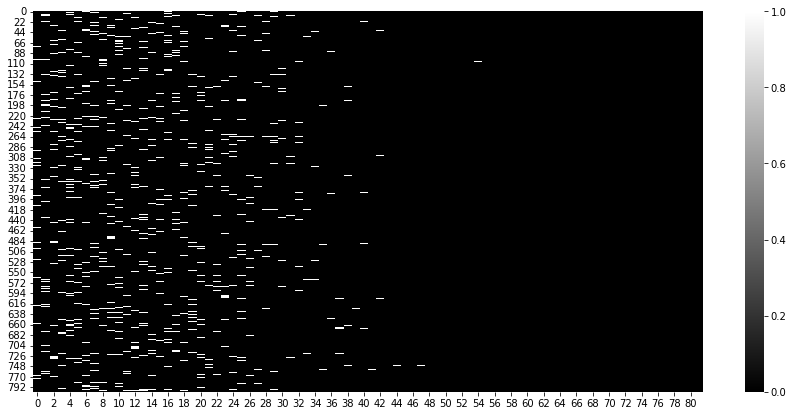

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);